# Introduction

This notebook shows techniques to work with big data.

# What is chunking in Pandas?

In Pandas, chunking means reading or processing large datasets in smaller pieces (called chunks) instead of loading everything into memory at once.

This is especially useful when working with very large files that would otherwise exceed your available RAM.

Instead of loading a huge file all at once with `pd.read_csv()`, you read it incrementally and process each part separately.

👉 Lower memory usage

If we try to load very large files normally, we’ll likely run out of memory.

# Chunking demo: Reducing memory load

For this demo, I will use data from the NYC TLC (New York City, Taxi & Limousine Commission):

https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page 


In [1]:
# Specify file to use
DATASET_DIR = "/home/juebrauer/link_to_vcd/10_datasets/63_nyc_taxis"
FILE = DATASET_DIR + "/yellow_tripdata_2025-01.csv"
FILE

'/home/juebrauer/link_to_vcd/10_datasets/63_nyc_taxis/yellow_tripdata_2025-01.csv'

In [2]:
# How large is this file?
import os
size_bytes = os.path.getsize(FILE)
size_mb = size_bytes / (1024 ** 2)
print(f"File size: {size_mb:.1f} MB")

File size: 359.3 MB


In [3]:
# Let us observe how many seconds we need to read in the file
import pandas
df = pandas.read_csv(FILE)
df.head()

/tmp/ipykernel_17478/4045297258.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pandas.read_csv(FILE)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,1,2025-01-01 00:18:38,2025-01-01 00:26:59,1.0,1.60,1.0,N,229,237,1,10.0,3.5,0.5,3.00,0.0,1.0,18.00,2.5,0.0,0.0
1,1,2025-01-01 00:32:40,2025-01-01 00:35:13,1.0,0.50,1.0,N,236,237,1,5.1,3.5,0.5,2.02,0.0,1.0,12.12,2.5,0.0,0.0
2,1,2025-01-01 00:44:04,2025-01-01 00:46:01,1.0,0.60,1.0,N,141,141,1,5.1,3.5,0.5,2.00,0.0,1.0,12.10,2.5,0.0,0.0
3,2,2025-01-01 00:14:27,2025-01-01 00:20:01,3.0,0.52,1.0,N,244,244,2,7.2,1.0,0.5,0.00,0.0,1.0,9.70,0.0,0.0,0.0
4,2,2025-01-01 00:21:34,2025-01-01 00:25:06,3.0,0.66,1.0,N,244,116,2,5.8,1.0,0.5,0.00,0.0,1.0,8.30,0.0,0.0,0.0


In [4]:
# Which features are available?
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee',
       'cbd_congestion_fee'],
      dtype='object')

What each column means is described here:
https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf 

| Field Name | Description |
|-----------|-------------|
| VendorID | A code indicating the TPEP provider that provided the record.<br>1 = Creative Mobile Technologies, LLC<br>2 = Curb Mobility, LLC<br>6 = Myle Technologies Inc<br>7 = Helix |
| tpep_pickup_datetime | The date and time when the meter was engaged. |
| tpep_dropoff_datetime | The date and time when the meter was disengaged. |
| passenger_count | The number of passengers in the vehicle. |
| trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| RatecodeID | The final rate code in effect at the end of the trip.<br>1 = Standard rate<br>2 = JFK<br>3 = Newark<br>4 = Nassau or Westchester<br>5 = Negotiated fare<br>6 = Group ride<br>99 = Null/unknown |
| store_and_fwd_flag | Indicates whether the trip record was held in vehicle memory before sending to the vendor (“store and forward”).<br>Y = store and forward trip<br>N = not a store and forward trip |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged. |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged. |
| payment_type | A numeric code signifying how the passenger paid for the trip.<br>0 = Flex Fare trip<br>1 = Credit card<br>2 = Cash<br>3 = No charge<br>4 = Dispute<br>5 = Unknown<br>6 = Voided trip |
| fare_amount | The time-and-distance fare calculated by the meter. |
| extra | Miscellaneous extras and surcharges. |
| mta_tax | Tax that is automatically triggered based on the metered rate in use. |
| tip_amount | Tip amount. Automatically populated for credit card tips. Cash tips are not included. |
| tolls_amount | Total amount of all tolls paid in trip. |
| improvement_surcharge | Improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
| congestion_surcharge | Total amount collected in trip for NYS congestion surcharge. |
| airport_fee | For pick up only at LaGuardia and John F. Kennedy Airports. |
| cbd_congestion_fee | Per-trip charge for MTA’s Congestion Relief Zone starting Jan 5, 2025. |



In [5]:
# This table is large
df.shape

(3475226, 20)

In [6]:
# Data type per colum seems to be ok
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3475226 entries, 0 to 3475225
Data columns (total 20 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          float64
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           int64  
 8   DOLocationID           int64  
 9   payment_type           int64  
 10  fare_amount            float64
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             float64
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           float64
 17  congestion_surcharge   float64
 18  Airport_fee            float64
 19  cbd_congestion_fee     float64
dtypes: float64(13), int64(4), object(3)
memory usage: 530.3+ MB


In [7]:
# However, something in the data is trange...
# -> Why are there negative fare/total amounts?
# -> Why is there a taxi ride with a total amount of $863K?
# -> Why is there a taxi ride with trip distance 276K miles?
# Also note that, e.g., some passenger_count values are missing in the table!
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
VendorID,3475226.0,1.785428,0.426328,1.00,2.00,2.00,2.00,7.00
passenger_count,2935077.0,1.297859,0.750750,0.00,1.00,1.00,1.00,9.00
trip_distance,3475226.0,5.855126,564.601600,0.00,0.98,1.67,3.10,276423.57
RatecodeID,2935077.0,2.482535,11.632772,1.00,1.00,1.00,1.00,99.00
PULocationID,3475226.0,165.191576,64.529483,1.00,132.00,162.00,234.00,265.00
DOLocationID,3475226.0,164.125177,69.401686,1.00,113.00,162.00,234.00,265.00
payment_type,3475226.0,1.036623,0.701333,0.00,1.00,1.00,1.00,5.00
fare_amount,3475226.0,17.081803,463.472918,-900.00,8.60,12.11,19.50,863372.12
extra,3475226.0,1.317737,1.861509,-7.50,0.00,0.00,2.50,15.00
mta_tax,3475226.0,0.478099,0.137462,-0.50,0.50,0.50,0.50,10.50


In [8]:
# Let us compute how much memory and time is needed
# to do some data processing
# We can see a high peak memory load

import tracemalloc
import time

tracemalloc.start()
t0 = time.perf_counter()

df = pandas.read_csv(FILE)
df2 = df.query("total_amount > 0 and total_amount < 1000")
df2 = df2.dropna()
mean_amount = df2["total_amount"].mean()
mean_nr_passengers = df2["passenger_count"].mean()

t1 = time.perf_counter()
current_a, peak_a = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"Mean amount: ${mean_amount:.2f}")
print(f"Mean number of passengers: {mean_nr_passengers:.1f}")
print(f"Time: {t1 - t0:.2f} s")
print(f"Peak memory (tracemalloc): {peak_a / (1024**2):.1f} MB")

/tmp/ipykernel_17478/2323637347.py:11: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pandas.read_csv(FILE)


Mean amount: $27.45
Mean number of passengers: 1.3
Time: 6.00 s
Peak memory (tracemalloc): 1996.4 MB


In [9]:
# Now the same with chunking
# The peak memory load will be much smaller!
CHUNK_SIZE = 100_000

import tracemalloc
import time

tracemalloc.start()
t0 = time.perf_counter()

sum_amount = 0
sum_nr_passengers = 0
N = 0
for chunk in pandas.read_csv(FILE, chunksize=CHUNK_SIZE):
    df2 = chunk.query("total_amount > 0 and total_amount < 1000")
    df2 = df2.dropna()
    sum_amount += df2["total_amount"].sum()
    sum_nr_passengers += df2["passenger_count"].sum()
    N += len(df2)
mean_amount = sum_amount / N
mean_nr_passengers = sum_nr_passengers / N    

t1 = time.perf_counter()
current_a, peak_a = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"Mean amount: ${mean_amount:.2f}")
print(f"Mean number of passengers: {mean_nr_passengers:.1f}")
print(f"Time: {t1 - t0:.2f} s")
print(f"Peak memory (tracemalloc): {peak_a / (1024**2):.1f} MB")

/tmp/ipykernel_17478/283414120.py:14: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pandas.read_csv(FILE, chunksize=CHUNK_SIZE):


Mean amount: $27.45
Mean number of passengers: 1.3
Time: 5.77 s
Peak memory (tracemalloc): 98.4 MB


# What are Parquet Files?

Nowadays, many large data files are provided as parquet files.

E.g., the NYC TLC organization switched to providing their data in parquet files:
https://www.nyc.gov/assets/tlc/downloads/pdf/working_parquet_format.pdf

        Working With Parquet Format

        TLC is switching to the Parquet file type for storing raw trip data on our website.
        Parquet is the industry standard for >working with big data.
        Using Parquet format results in reduced file sizes and increased speeds.
        However, we have been using >the CSV format for a while and
        the Parquet format might be new to some users.

Parquet files are a columnar data storage format mainly used in big data and analytics.

They’re designed to be fast, efficient, and compact—especially when working with large datasets.

- Benefit 1: Column-based storage
Instead of storing data row by row (like CSV), Parquet stores data column by column.
This makes reading specific columns much faster.

- Benefit 2: Highly compressed
Because values in a column are often similar, Parquet compresses data very well, saving disk space. File format is a binary data format, i.e., numbers are stored efficiently.

        E.g.,

        1,DE,ACTIVE
        2,DE,ACTIVE
        3,DE,ACTIVE
        4,US,ACTIVE

        can be stored like this:

        id:      1, 2, 3, 4
        country: DE, DE, DE, US
        status:  ACTIVE, ACTIVE, ACTIVE, ACTIVE

        or much more efficient like this using Run-length encoding (RLE):

        id:      1, 2, 3
        country: 3xDE, US
        status:  4xACTIVE


- Benefit 3: Schema-aware
Data types (int, string, timestamp, etc.) are stored with the file, so tools know exactly how to interpret the data.

Common tools that use Parquet:
- Apache Spark
- Apache Hive
- Apache Arrow
- Pandas (via PyArrow or Fastparquet)
- BigQuery, Snowflake, AWS Athena



# Historical background of Parquet files

The Parquet file format was invented by engineers at Twitter and Cloudera.

More specifically:
- Julien Le Dem (then at Twitter)
- Dain Sundstrom (then at Twitter)
- Along with contributors from Cloudera

When and why:
- Created around 2013
- Built to solve performance and storage problems in Hadoop-based analytics
- Designed as a columnar, compressed, analytics-optimized format

What happened next:
- Parquet was open-sourced
- Donated to the Apache Software Foundation
- Became Apache Parquet, now an industry standard

# Parquet file demo: Correct data types, reduced hdd and RAM size

In [10]:
# Specify files to use
DATASET_DIR = "/home/juebrauer/link_to_vcd/10_datasets/63_nyc_taxis"
FILE1 = DATASET_DIR + "/yellow_tripdata_2025-01.csv"
FILE2 = DATASET_DIR + "/yellow_tripdata_2025-01.parquet"
print(FILE1)
print(FILE2)

/home/juebrauer/link_to_vcd/10_datasets/63_nyc_taxis/yellow_tripdata_2025-01.csv
/home/juebrauer/link_to_vcd/10_datasets/63_nyc_taxis/yellow_tripdata_2025-01.parquet


In [11]:
# How large are these files?
import os

size_mb = os.path.getsize(FILE1) / (1024**2)
print(f"File size {FILE1}: {size_mb:.1f} MB")

size_mb = os.path.getsize(FILE2) / (1024**2)
print(f"File size {FILE2}: {size_mb:.1f} MB")

File size /home/juebrauer/link_to_vcd/10_datasets/63_nyc_taxis/yellow_tripdata_2025-01.csv: 359.3 MB
File size /home/juebrauer/link_to_vcd/10_datasets/63_nyc_taxis/yellow_tripdata_2025-01.parquet: 56.4 MB


In [12]:
# Read in .csv file and observe
# reading time and memory usage

import tracemalloc
import time
tracemalloc.start()
t0 = time.perf_counter()

df = pandas.read_csv(FILE1)

t1 = time.perf_counter()
current_a, peak_a = tracemalloc.get_traced_memory()
tracemalloc.stop()
print(f"Time: {t1 - t0:.2f} s")
print(f"Peak memory (tracemalloc): {peak_a / (1024**2):.1f} MB")

/tmp/ipykernel_17478/1288739546.py:9: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pandas.read_csv(FILE1)


Time: 5.43 s
Peak memory (tracemalloc): 1996.3 MB


In [13]:
# Show memory usage and data types
# Please note, ...
# 1. the data types for the pickup/dropoff datetime timestamps are not correct
# 2. since the datetime information is stored internally as object (strings), we have a high memory load
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3475226 entries, 0 to 3475225
Data columns (total 20 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          float64
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           int64  
 8   DOLocationID           int64  
 9   payment_type           int64  
 10  fare_amount            float64
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             float64
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           float64
 17  congestion_surcharge   float64
 18  Airport_fee            float64
 19  cbd_congestion_fee     float64
dtypes: float64(13), int64(4), object(3)
memory usage: 1.0 GB


In [14]:
# Show memory usage per column
df.memory_usage(deep=True)

Index                          132
VendorID                  27801808
tpep_pickup_datetime     236315368
tpep_dropoff_datetime    236315368
passenger_count           27801808
trip_distance             27801808
RatecodeID                27801808
store_and_fwd_flag       164038618
PULocationID              27801808
DOLocationID              27801808
payment_type              27801808
fare_amount               27801808
extra                     27801808
mta_tax                   27801808
tip_amount                27801808
tolls_amount              27801808
improvement_surcharge     27801808
total_amount              27801808
congestion_surcharge      27801808
Airport_fee               27801808
cbd_congestion_fee        27801808
dtype: int64

In [15]:
# Compute total memory usage based on the column memory usages
mem_bytes = df.memory_usage(deep=True).sum()
mem_mb = mem_bytes / 1024**2
print(f"{mem_mb:.2f} MB")

1057.91 MB


In [16]:
# Read in .parquet file and observe
# reading time and memory usage

import tracemalloc
import time
tracemalloc.start()
t0 = time.perf_counter()

df = pandas.read_parquet(FILE2)

t1 = time.perf_counter()
current_a, peak_a = tracemalloc.get_traced_memory()
tracemalloc.stop()
print(f"Time: {t1 - t0:.2f} s")
print(f"Peak memory (tracemalloc): {peak_a / (1024**2):.1f} MB")

Time: 0.33 s
Peak memory (tracemalloc): 57.5 MB


In [17]:
# Now, the pickup/dropoff information is correctly stored as datetime timestamps
# resulting in a smaller memory load for the table
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3475226 entries, 0 to 3475225
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

In [18]:
# Show memory usage per column
df.memory_usage(deep=True)

Index                          132
VendorID                  13900904
tpep_pickup_datetime      27801808
tpep_dropoff_datetime     27801808
passenger_count           27801808
trip_distance             27801808
RatecodeID                27801808
store_and_fwd_flag       159717426
PULocationID              13900904
DOLocationID              13900904
payment_type              27801808
fare_amount               27801808
extra                     27801808
mta_tax                   27801808
tip_amount                27801808
tolls_amount              27801808
improvement_surcharge     27801808
total_amount              27801808
congestion_surcharge      27801808
Airport_fee               27801808
cbd_congestion_fee        27801808
dtype: int64

In [19]:
# Compute total memory usage based on the column memory usages
mem_bytes = df.memory_usage(deep=True).sum()
mem_mb = mem_bytes / 1024**2
print(f"{mem_mb:.2f} MB")

616.31 MB


# Parquet files allow to read in specific columns

Sometimes this is also called "column pruning"

In [20]:
# Specify files to use
DATASET_DIR = "/home/juebrauer/link_to_vcd/10_datasets/63_nyc_taxis"
FILE1 = DATASET_DIR + "/yellow_tripdata_2025-01.csv"
FILE2 = DATASET_DIR + "/yellow_tripdata_2025-01.parquet"
print(FILE1)
print(FILE2)

/home/juebrauer/link_to_vcd/10_datasets/63_nyc_taxis/yellow_tripdata_2025-01.csv
/home/juebrauer/link_to_vcd/10_datasets/63_nyc_taxis/yellow_tripdata_2025-01.parquet


In [21]:
import pandas as pd
import tracemalloc
import time

tracemalloc.start()
t0 = time.perf_counter()

# Pandas will read in rows by rows but discard
# all columns values but the selected ones in usecols
df = pd.read_csv(FILE1, usecols=["passenger_count", "total_amount"])

t1 = time.perf_counter()
current_a, peak_a = tracemalloc.get_traced_memory()
tracemalloc.stop()
print(f"Time: {t1 - t0:.2f} s")
print(f"Peak memory (tracemalloc): {peak_a / (1024**2):.1f} MB")

Time: 1.27 s
Peak memory (tracemalloc): 106.1 MB


In [22]:
df

,passenger_count,total_amount
0,1.0,18.00
1,1.0,12.12
2,1.0,12.10
3,3.0,9.70
4,3.0,8.30
...,...,...
3475221,NaN,20.60
3475222,NaN,32.89
3475223,NaN,19.66
3475224,NaN,22.30


In [23]:
df.describe()

,passenger_count,total_amount
count,2.935077e+06,3.475226e+06
mean,1.297859e+00,2.561129e+01
std,7.507503e-01,4.636585e+02
min,0.000000e+00,-9.010000e+02
25%,1.000000e+00,1.520000e+01
50%,1.000000e+00,1.995000e+01
75%,1.000000e+00,2.778000e+01
max,9.000000e+00,8.633804e+05


In [24]:
df["total_amount"].quantile(0.99)

102.92

In [25]:
import pandas as pd
import tracemalloc
import time

tracemalloc.start()
t0 = time.perf_counter()

# Pandas will read only the selected columns
df = pd.read_parquet(FILE2, columns=["passenger_count", "total_amount"])

t1 = time.perf_counter()
current_a, peak_a = tracemalloc.get_traced_memory()
tracemalloc.stop()
print(f"Time: {t1 - t0:.2f} s")
print(f"Peak memory (tracemalloc): {peak_a / (1024**2):.1f} MB")

Time: 0.08 s
Peak memory (tracemalloc): 6.1 MB


In [26]:
df["total_amount"].quantile(0.99)

102.92

# Parquet files allow for filtered reading

So called "predicate pushdown"

In [27]:
import pandas

df = pandas.read_parquet(FILE2,
                         filters=[("tip_amount", ">", 5),
                                  ("passenger_count", "==", 2)]
)

mean_tip_in_percent_of_amount = (df["tip_amount"] / df["total_amount"]).mean()*100
mean_tip_in_percent_of_amount

17.29676746854082

In [28]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,2,2025-01-01 00:25:03,2025-01-01 00:54:59,2,5.17,1,N,211,263,1,28.9,1.00,0.5,6.78,0.00,1.0,40.68,2.5,0.00,0.00
1,2,2025-01-01 00:33:54,2025-01-01 01:04:28,2,3.46,1,N,237,249,1,26.8,1.00,0.5,7.20,0.00,1.0,39.00,2.5,0.00,0.00
2,2,2025-01-01 00:11:59,2025-01-01 00:48:37,2,9.17,1,N,138,186,1,48.5,6.00,0.5,13.09,6.94,1.0,80.28,2.5,1.75,0.00
3,1,2025-01-01 00:44:08,2025-01-01 01:10:46,2,4.50,1,N,79,142,1,26.1,3.50,0.5,9.30,0.00,1.0,40.40,2.5,0.00,0.00
4,1,2025-01-01 00:12:31,2025-01-01 00:31:32,2,4.00,1,N,236,42,1,21.2,3.50,0.5,6.55,0.00,1.0,32.75,2.5,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79189,2,2025-01-31 23:02:32,2025-01-31 23:39:57,2,17.68,2,N,132,230,1,70.0,0.00,0.5,16.34,6.94,1.0,99.78,2.5,1.75,0.75
79190,1,2025-01-31 23:53:21,2025-02-01 00:15:13,2,5.40,1,N,231,239,1,26.8,4.25,0.5,8.10,0.00,1.0,40.65,2.5,0.00,0.75
79191,2,2025-01-31 23:09:30,2025-01-31 23:30:49,2,2.91,1,N,43,90,1,19.8,1.00,0.5,5.11,0.00,1.0,30.66,2.5,0.00,0.75
79192,2,2025-01-31 23:10:31,2025-01-31 23:47:50,2,20.62,2,N,132,239,1,70.0,0.00,0.5,20.23,6.94,1.0,102.92,2.5,1.75,0.00


# What are Feather files?

In contrast, to .csv files, both are binary file formats, but:

Feather files = design goal: extreme fast reading / writing from disk

Parquet files = design goal: small data files and selective reading

| Feature | **Feather** | **Parquet** |
|--------|-------------|-------------|
| Primary purpose | Very fast data exchange | Efficient, long-term storage |
| Read speed | ⚡ Extremely fast | Fast, but slower than Feather |
| Write speed | ⚡ Extremely fast | Medium |
| Compression | ❌ None | ✅ Very good (Snappy, Gzip, ZSTD …) |
| File size | Large | Significantly smaller |
| Data types | Simple | Very rich (nested, lists, structs) |
| Metadata | Minimal | Extensive |
| Scalability | Single-file use | Big data & distributed systems |
| Typical use cases | Data science, cache | Data lakes, analytics |


Why Feather is so fast:

Feather is built on Apache Arrow.

👉 Arrow is a memory format designed for RAM.
👉 Feather writes this in-memory representation almost unchanged to disk.

That’s why loading is extremely cheap: read the file, map it into memory, done

With CSV or Parquet, more work is required:
- decode text or encodings
- decompress data
- reconstruct data types
- process metadata

Bottom line:
Feather is fast because it’s essentially a memory snapshot, while CSV and Parquet are storage-oriented formats that require extra processing when loading.


Tips:
- Use Feather when you want speed and simplicity.
- Use Parquet when you want efficiency and scalability.
- Feather = fast cache
- Parquet = serious storage


# Feather file demo: Differences to .csv and .parquet

In [29]:
DATASET_DIR = "/home/juebrauer/link_to_vcd/10_datasets/63_nyc_taxis"
FILE2 = DATASET_DIR + "/yellow_tripdata_2025-01.parquet"
FILE3 = DATASET_DIR + "/yellow_tripdata_2025-01.feather"
FILE3

'/home/juebrauer/link_to_vcd/10_datasets/63_nyc_taxis/yellow_tripdata_2025-01.feather'

In [30]:
import pandas
df = pandas.read_parquet(FILE2)

df.to_feather(FILE3)

In [31]:
# Feather files have smaller size than .csv files
# since they are binary
# However, file size is larger than .parquet files
# because no data compression is used
import os

size_mb = os.path.getsize(FILE1) / (1024**2)
print(f"File size {FILE1}: {size_mb:.1f} MB")

size_mb = os.path.getsize(FILE2) / (1024**2)
print(f"File size {FILE2}: {size_mb:.1f} MB")

size_mb = os.path.getsize(FILE3) / (1024**2)
print(f"File size {FILE3}: {size_mb:.1f} MB")

File size /home/juebrauer/link_to_vcd/10_datasets/63_nyc_taxis/yellow_tripdata_2025-01.csv: 359.3 MB
File size /home/juebrauer/link_to_vcd/10_datasets/63_nyc_taxis/yellow_tripdata_2025-01.parquet: 56.4 MB
File size /home/juebrauer/link_to_vcd/10_datasets/63_nyc_taxis/yellow_tripdata_2025-01.feather: 122.8 MB


# Quiz: Tips in percent for each month -> Is there a pattern?

Reading /home/juebrauer/link_to_vcd/10_datasets/63_nyc_taxis/yellow_tripdata_2025-01.parquet ... --> tip in percent: 10.5%
Reading /home/juebrauer/link_to_vcd/10_datasets/63_nyc_taxis/yellow_tripdata_2025-02.parquet ... --> tip in percent: 9.7%
Reading /home/juebrauer/link_to_vcd/10_datasets/63_nyc_taxis/yellow_tripdata_2025-03.parquet ... --> tip in percent: 9.7%
Reading /home/juebrauer/link_to_vcd/10_datasets/63_nyc_taxis/yellow_tripdata_2025-04.parquet ... --> tip in percent: 10.0%
Reading /home/juebrauer/link_to_vcd/10_datasets/63_nyc_taxis/yellow_tripdata_2025-05.parquet ... --> tip in percent: 9.1%
Reading /home/juebrauer/link_to_vcd/10_datasets/63_nyc_taxis/yellow_tripdata_2025-06.parquet ... --> tip in percent: 8.9%
Reading /home/juebrauer/link_to_vcd/10_datasets/63_nyc_taxis/yellow_tripdata_2025-07.parquet ... --> tip in percent: 8.7%
Reading /home/juebrauer/link_to_vcd/10_datasets/63_nyc_taxis/yellow_tripdata_2025-08.parquet ... --> tip in percent: 8.7%
Reading /home/juebraue

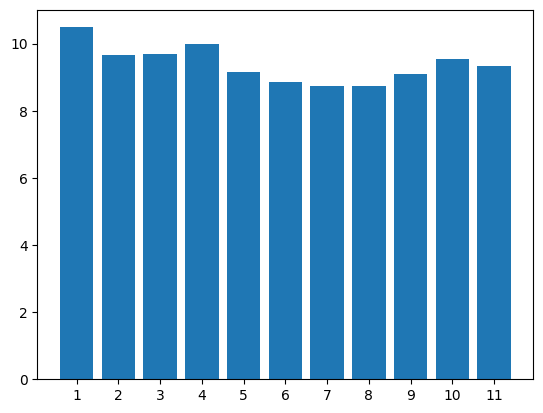

In [44]:
# Now, read in the data from all available 2025 months: 1 - 11
# Note, data for 12/2025 is not yet available!

DATASET_DIR = "/home/juebrauer/link_to_vcd/10_datasets/63_nyc_taxis"

avg_tips_per_month = []

for month_nr in range(1,12):

    filename = f"{DATASET_DIR}/yellow_tripdata_2025-{month_nr:02}.parquet"
    print(f"Reading {filename} ...", end=" ")

    # read all data -> slower
    # df = pd.read_parquet(filename) 

    # only read data we need -> faster
    df = pd.read_parquet(filename, columns=["passenger_count", "total_amount", "tip_amount"])

    tip_in_percent_of_amount = (df["tip_amount"] / df["total_amount"]).mean() * 100.0
    print(f"--> tip in percent: {tip_in_percent_of_amount:.1f}%")

    avg_tips_per_month.append( tip_in_percent_of_amount )

# Tips are lower in warm months compared to cold months
import matplotlib.pyplot as plt
plt.bar( range(1,12), avg_tips_per_month)
plt.xticks(range(1,12))
plt.show()    

# Sparse columns for large tables

In large pandas tables (DataFrames), sparse and categorical describe how data is represented and stored, with big implications for memory usage and performance.

Sparse means that most values are the same, usually zero or missing (NaN), and pandas stores only the non-default values.

Benefits:
- Saves a lot of memory for wide or large tables
- Faster for some operations when data is mostly empty

Note:
- Default value is usually 0 or NaN
- Arithmetic works mostly as usual
- Some operations may convert sparse back to dense

In [45]:
import pandas as pd
import numpy as np

# ----------------------------
# 1. Create mostly-zero data
# ----------------------------
n = 1_000_000  # one million rows

dense = pd.Series(np.zeros(n, dtype=np.int64))
dense.iloc[[10, 200_000, 700_000]] = [5, 3, 9]

# Convert to sparse dtype
sparse = dense.astype("Sparse[int]")

# ----------------------------
# 2. Compare memory usage
# ----------------------------
dense_mem = dense.memory_usage(deep=True)
sparse_mem = sparse.memory_usage(deep=True)

print("Memory usage for a single column:")
print(f"Dense column:  {dense_mem / 1024:.2f} KB")
print(f"Sparse column: {sparse_mem / 1024:.2f} KB")
print(f"Saved memory:  {(dense_mem - sparse_mem) / 1024:.2f} KB")

# ----------------------------
# 3. Put both into a DataFrame
# ----------------------------
df = pd.DataFrame({
    "dense_col": dense,
    "sparse_col": sparse
})

print("\nMemory usage inside a DataFrame:")
print(df.memory_usage(deep=True))

# ----------------------------
# 4. Show sparsity level
# ----------------------------
non_zero_count = (dense != 0).sum()
print(f"\nNon-zero values: {non_zero_count} out of {n} rows")


Memory usage for a single column:
Dense column:  7812.63 KB
Sparse column: 0.16 KB
Saved memory:  7812.46 KB

Memory usage inside a DataFrame:
Index             132
dense_col     8000000
sparse_col         36
dtype: int64

Non-zero values: 3 out of 1000000 rows


In [46]:
dense

0         0
1         0
2         0
3         0
4         0
         ..
999995    0
999996    0
999997    0
999998    0
999999    0
Length: 1000000, dtype: int64

In [47]:
sparse

0         0
1         0
2         0
3         0
4         0
         ..
999995    0
999996    0
999997    0
999998    0
999999    0
Length: 1000000, dtype: Sparse[int64, 0]

In [48]:
df

,dense_col,sparse_col
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
999995,0,0
999996,0,0
999997,0,0
999998,0,0


# Categorical columns for large tables

Categorical means values come from a small, fixed set of labels, even if the table is huge.

Instead of storing each string repeatedly, pandas stores:
- A category dictionary
- Integer codes referencing that dictionary

Benefits:
- Massive memory savings for repeated strings
- Faster grouping, sorting, and comparisons
- Enforces valid values (no typos)

In [49]:
import pandas as pd
import numpy as np

# -----------------------------------
# 1. Create repeated string data
# -----------------------------------
n = 1_000_000  # one million rows

statuses = np.random.choice(
    ["active", "inactive", "pending"],
    size=n,
    p=[0.6, 0.3, 0.1]
)

# Object dtype (default for strings)
obj_series = pd.Series(statuses)

# Categorical dtype
cat_series = obj_series.astype("category")

# -----------------------------------
# 2. Compare memory usage
# -----------------------------------
obj_mem = obj_series.memory_usage(deep=True)
cat_mem = cat_series.memory_usage(deep=True)

print("Memory usage for a single column:")
print(f"Object (string): {obj_mem / 1024:.2f} KB")
print(f"Categorical:     {cat_mem / 1024:.2f} KB")
print(f"Saved memory:    {(obj_mem - cat_mem) / 1024:.2f} KB")

# -----------------------------------
# 3. Put both into a DataFrame
# -----------------------------------
df = pd.DataFrame({
    "object_col": obj_series,
    "category_col": cat_series
})

print("\nMemory usage inside a DataFrame:")
print(df.memory_usage(deep=True))

# -----------------------------------
# 4. Show category internals
# -----------------------------------
print("\nCategories:")
print(cat_series.cat.categories)

print("\nCategory codes (first 10 rows):")
print(cat_series.cat.codes.head(10))


Memory usage for a single column:
Object (string): 54395.08 KB
Categorical:     976.96 KB
Saved memory:    53418.12 KB

Memory usage inside a DataFrame:
Index                132
object_col      55700430
category_col     1000276
dtype: int64

Categories:
Index(['active', 'inactive', 'pending'], dtype='object')

Category codes (first 10 rows):
0    0
1    0
2    1
3    0
4    2
5    0
6    1
7    0
8    0
9    1
dtype: int8


In [50]:
obj_series

0           active
1           active
2         inactive
3           active
4          pending
            ...   
999995      active
999996      active
999997    inactive
999998      active
999999      active
Length: 1000000, dtype: object

In [51]:
cat_series

0           active
1           active
2         inactive
3           active
4          pending
            ...   
999995      active
999996      active
999997    inactive
999998      active
999999      active
Length: 1000000, dtype: category
Categories (3, object): ['active', 'inactive', 'pending']

In [55]:
cat_series.cat.categories

Index(['active', 'inactive', 'pending'], dtype='object')

In [56]:
cat_series.cat.codes

0         0
1         0
2         1
3         0
4         2
         ..
999995    0
999996    0
999997    1
999998    0
999999    0
Length: 1000000, dtype: int8